In [17]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix 
import pandas as pd

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

In [20]:
# get data and resize image
def get_data(data_dir, labels):
    data=[]
    for label in labels: 
        path = os.path.join(data_dir, label)
        index_label = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resize_img_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resize_img_arr, index_label])
            except Exception as e:
                print(e)
    return data 

### Load Dataset

In [21]:
data_train = get_data('../input/chest_xray/train', labels)
data_test = get_data('../tugas-kelompok/input/chest_xray/test', labels)


In [22]:
print(f'Data Train: {len(data_train)}')
print(f'Data Test: {len(data_test)}')
print(f'Total data = {len(data_train) + len(data_test)}')

Data Train: 5216
Data Test: 624
Total data = 5840


## Data Visualization

Pneumonia: 3875
Normal: 1341


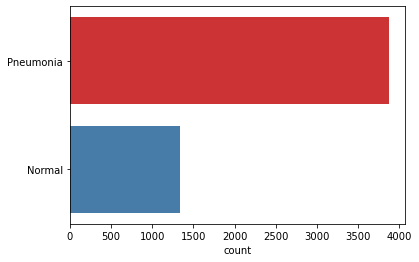

In [23]:
data_count = []
count_pneumonia = 0
count_normal = 0
for data in data_train:
    if(data[1] == 0):
        count_pneumonia = count_pneumonia + 1
        data_count.append('Pneumonia')
    else:
        count_normal = count_normal + 1
        data_count.append('Normal')

sns.countplot(y=data_count, palette="Set1")

print(f'Pneumonia: {count_pneumonia}')
print(f'Normal: {count_normal}')


Text(0.5, 1.0, 'NORMAL')

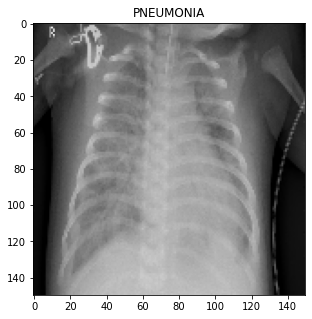

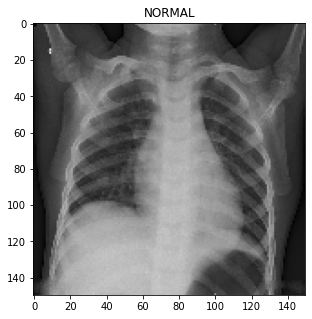

In [24]:
plt.figure(figsize=(5,5))
plt.imshow(data_train[0][0], cmap="gray")
plt.title(labels[data_train[0][1]])

plt.figure(figsize=(5,5))
plt.imshow(data_train[-1][0], cmap="gray")
plt.title(labels[data_train[-1][-1]])


In [25]:
X_train = []
X_test = []

y_train = []
y_test = []

for feature, label in data_train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in data_test:
    X_test.append(feature)
    y_test.append(label)


In [26]:
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

In [27]:
# resize data for deep learning
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)

y_train = np.array(y_train)
y_test = np.array(y_test)

### Data Augmentation

In [28]:
# documentation https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=30,
        zoom_range=0.3,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)

datagen.fit(X_train)

## Training Model


In [101]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu', input_shape=[img_size, img_size, 1]))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.MaxPool2D((2,2)))

# model.add(layers.Conv2D(128, (3,3), activation='relu'))
# model.add(layers.MaxPool2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 74, 74, 32)        320       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_114 (Conv2D)         (None, 19, 19, 32)        9248      
                                                                 
 conv2d_115 (Conv2D)         (None, 19, 19, 32)        9248      
                                                                 
 dropout_38 (Dropout)        (None, 19, 19, 32)        0         
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 9, 9, 32)         0         
 g2D)                                                

In [102]:
epochs = 30
optimizer = 'adam'

In [103]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(datagen.flow(X_train,
                     y_train, batch_size=32), 
                    epochs=epochs,
                    validation_data=(X_test, y_test))

Epoch 1/30
163/163 [==============================] - 9s 52ms/step - loss: 0.6296 - accuracy: 0.7368 - val_loss: 0.6151 - val_accuracy: 0.6362
Epoch 2/30
163/163 [==============================] - 8s 50ms/step - loss: 0.4080 - accuracy: 0.8135 - val_loss: 0.4681 - val_accuracy: 0.7596
Epoch 3/30
163/163 [==============================] - 8s 49ms/step - loss: 0.3313 - accuracy: 0.8558 - val_loss: 0.3650 - val_accuracy: 0.8333
Epoch 4/30
163/163 [==============================] - 8s 49ms/step - loss: 0.2834 - accuracy: 0.8783 - val_loss: 0.3655 - val_accuracy: 0.8205
Epoch 5/30
163/163 [==============================] - 8s 48ms/step - loss: 0.2781 - accuracy: 0.8800 - val_loss: 0.3299 - val_accuracy: 0.8638
Epoch 6/30
163/163 [==============================] - 8s 50ms/step - loss: 0.2448 - accuracy: 0.8970 - val_loss: 0.3194 - val_accuracy: 0.8718
Epoch 7/30
163/163 [==============================] - 8s 50ms/step - loss: 0.2142 - accuracy: 0.9112 - val_loss: 0.5033 - val_accuracy: 0.8253

## Analysis Model

In [117]:
evaluate_loss = model.evaluate(X_test, y_test)[0]
evaluate_accuracy = model.evaluate(X_test, y_test)[1]*100
print(f'Loss Model: {evaluate_loss}')
print(f'Accuracy Model: {evaluate_accuracy} %')

20/20 [==============================] - 0s 4ms/step - loss: 0.3055 - accuracy: 0.9103
Loss Model: 0.3055115342140198
Accuracy Model: 91.02563858032227 %


In [118]:
epochs_range = [i for i in range(epochs)]

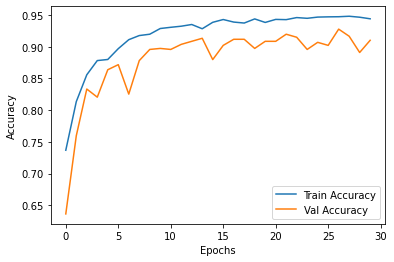

In [119]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs_range, accuracy, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

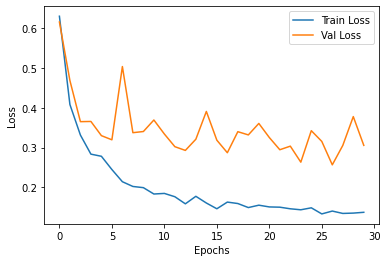

In [120]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [108]:
predic_x = model.predict(X_test)
predictions = np.argmax(predic_x, axis=1)
predictions = predictions.reshape(1,-1)[0]
predictions[-15:]


20/20 [==============================] - 0s 3ms/step


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [109]:
import itertools

def plot_confusion_matrix(confusion_matr, 
                        classes,
                        normalize=False,
                        title="Confusion Matrix",
                        cmap=plt.cm.Blues):
    plt.imshow(confusion_matr, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = confusion_matr.max() / 2.
    for i, j in itertools.product(range(confusion_matr.shape[0]),
                                    range(confusion_matr.shape[1])):
        plt.text(j, i, confusion_matr[i, j],
        horizontalalignment='center',
        color='white' if confusion_matr[i, j] > thresh else 'black')
    plt.tight_layout()
 

In [110]:
cf_matrix = confusion_matrix(y_test, predictions)
cf_matrix

array([[373,  17],
       [ 39, 195]], dtype=int64)

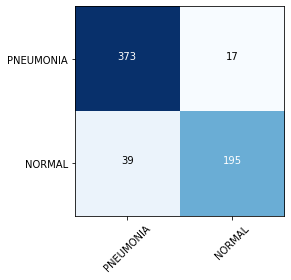

In [111]:
plot_confusion_matrix(cf_matrix, labels, title='')

In [112]:
tn, fp, fn, tp = cf_matrix.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn+fp)

print(f'Recal: {recall}')
print(f'Specificity: {specificity}')
print(f'Precision: {precision}')

Recal: 0.8333333333333334
Specificity: 0.9564102564102565
Precision: 0.9198113207547169


## 

In [ ]:
model.save(os.getcwd() + "/mModel")